In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from stochastic_dynamics.models import DeepLagEmbed
from stochastic_dynamics.generators import tvar
from stochastic_dynamics.utils import train_loop, bench_loop
from stochastic_dynamics.plottings import plot_history, plot_coefficients_by_p, plot_tvar_sample

from torchinfo import summary

In [2]:
def generate_dataset(n_samples, p_min=2, p_max=6, T=600):
    X = np.zeros((n_samples, T))
    coeffs_all = np.zeros((n_samples, T, p_max))
    p_true = np.zeros(n_samples, dtype=np.int64)
    
    for i in tqdm(range(n_samples)):
        p = np.random.randint(p_min, p_max + 1)
        x, coeffs = tvar(p, T=T)
        X[i] = x
        coeffs_all[i, :, :p] = coeffs
        p_true[i] = p - p_min  # 0-indexed for cross entropy
    
    return X, coeffs_all, p_true

In [3]:
# Generate data
# X_train, coef_train, p_train = generate_dataset(10000, p_min=2, p_max=6)
# X_val, coef_val, p_val = generate_dataset(1000, p_min=2, p_max=6)

# np.savez_compressed('model/tvar_dataset.npz',
#                     X_train=X_train, coef_train=coef_train, p_train=p_train,
#                     X_val=X_val, coef_val=coef_val, p_val=p_val)

d = np.load('model/tvar_dataset.npz')
X_train, coef_train, \
    p_train, X_val, coef_val, p_val = [d[k][:] for k in ['X_train', 'coef_train', 
                                                      'p_train', 'X_val', 'coef_val', 'p_val']]
d.close()

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    torch.cuda.init()
print(f"Using device: {device}")

# To tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
p_train = torch.tensor(p_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
p_val = torch.tensor(p_val, dtype=torch.long)
train_loader = DataLoader(TensorDataset(X_train, p_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, p_val), batch_size=32)

Using device: cuda


In [5]:
def do_bench_on_config(lambda_config):
    
    # hyperparameters
    n_epochs = 20
    lr = 1e-3
    max_ar_order = 6
    

    # Model: n_classes=5 for p∈{2,3,4,5,6}, max_ar_order=6 for coefficient dimensions
    model = DeepLagEmbed(seq_len=600, n_classes=5, max_ar_order=6, hidden_dim=128)
    model = model.to(device)

    # summary(model, input_size=(32, 600), device=device)

    # Train
    history = train_loop(
        model, train_loader, val_loader,
        n_epochs=n_epochs, lr=lr,
        lambda_p=lambda_config["lambda_p"], lambda_ar=lambda_config["lambda_ar"], lambda_energy=lambda_config["lambda_energy"], 
        lambda_smooth=lambda_config["lambda_smooth"], lambda_order=lambda_config["lambda_order"],
        p_max=max_ar_order, device=device
    )
    return model, history

In [6]:
# Full Model
# No AR(P)
# No P CE 
# No Energy
# No Smooth

ablation_config = {
    "full": {
        "lambda_ar": 5.0,
        "lambda_p": 4.0,
        "lambda_order": 1,
        "lambda_energy": 0.1,
        "lambda_smooth": 3
    },
    "no_ar": {
        "lambda_ar": 0,
        "lambda_p": 4.0,
        "lambda_order": 1,
        "lambda_energy": 0.1,
        "lambda_smooth": 3
    },
    "no_p": {
        "lambda_ar": 5.0,
        "lambda_p": 0,
        "lambda_order": 1,
        "lambda_energy": 0.1,
        "lambda_smooth": 3
    },
    "no_energy": {
        "lambda_ar": 5.0,
        "lambda_p": 4.0,
        "lambda_order": 1,
        "lambda_energy": 0,
        "lambda_smooth": 3
    },
    "no_smooth": {
        "lambda_ar": 5.0,
        "lambda_p": 4.0,
        "lambda_order": 1,
        "lambda_energy": 0.1,
        "lambda_smooth": 0
    }
}


In [7]:
ablation_config["full"]

{'lambda_ar': 5.0,
 'lambda_p': 4.0,
 'lambda_order': 1,
 'lambda_energy': 0.1,
 'lambda_smooth': 3}

Training: 100%|██████████| 20/20 [00:11<00:00,  1.74it/s, p_acc=0.449, train=2.0951, val=15.0479]


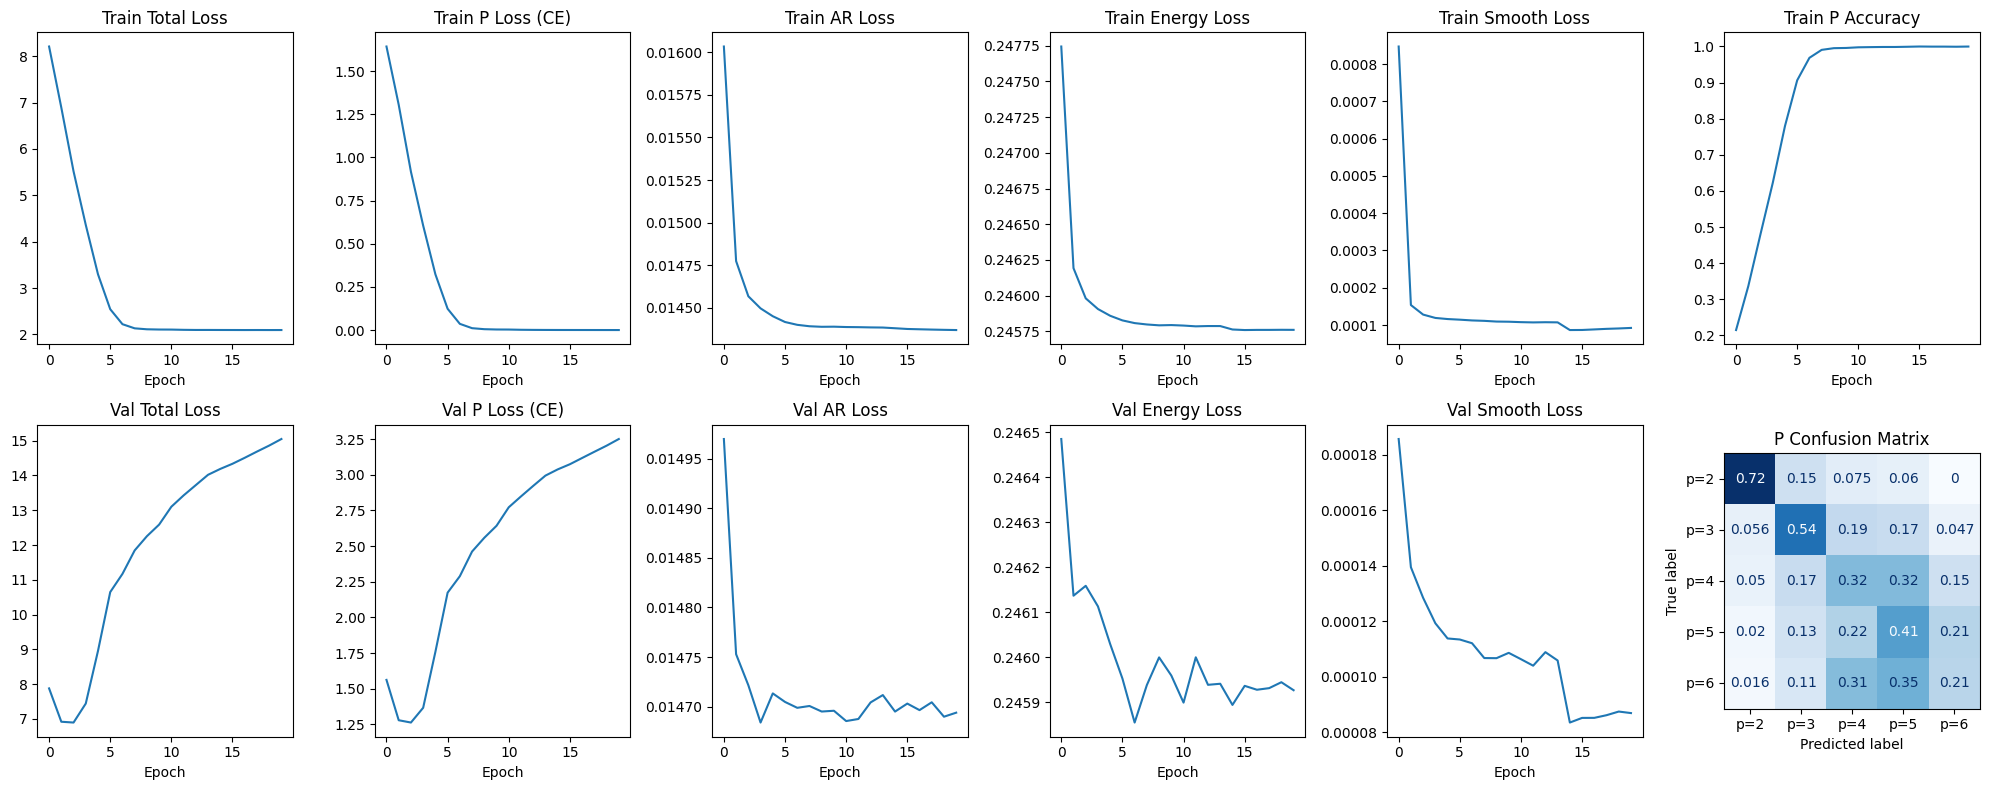

{'coeff_mse': 0.004016941073880282, 'signal_mse': 0.014701064676046371, 'p2_acc': 0.7412935323383084, 'p3_acc': 0.5467289719626168, 'p4_acc': 0.32673267326732675, 'p5_acc': 0.3880597014925373, 'p6_acc': 0.23076923076923078, 'p_acc': 0.452}


In [ ]:
model, history = do_bench_on_config(ablation_config["full"])
plot_history(history, model=model, val_loader=val_loader, device=device)
bench_results = bench_loop(model, X_val, coef_val, p_val, device)
for k, v in bench_results.items():
    print(f"k")

In [ ]:
model, history = do_bench_on_config(ablation_config["no_ar"])
plot_history(history, model=model, val_loader=val_loader, device=device)
bench_results = bench_loop(model, X_val, coef_val, p_val, device)
print(bench_results)

In [ ]:
model, history = do_bench_on_config(ablation_config["no_p"])
plot_history(history, model=model, val_loader=val_loader, device=device)
bench_results = bench_loop(model, X_val, coef_val, p_val, device)
print(bench_results)

In [ ]:
model, history = do_bench_on_config(ablation_config["no_energy"])
plot_history(history, model=model, val_loader=val_loader, device=device)
bench_results = bench_loop(model, X_val, coef_val, p_val, device)
print(bench_results)

In [ ]:
model, history = do_bench_on_config(ablation_config["no_smooth"])
plot_history(history, model=model, val_loader=val_loader, device=device)
bench_results = bench_loop(model, X_val, coef_val, p_val, device)
print(bench_results)